# Spark ML

#### Máster en Data Science y Big Data, AFI Escuela de Finanzas
#### Claudia Quintana Wong

Haciendo uso de Spark ML, se requiere desarrollar un modelo de regresión que permita predecir la popularidad (hotness) que tendrá una canción en base al resto de información suministrada. Se deberán tener en cuenta los siguientes puntos:

* Se debe entregar todo el código necesario para:

    * Carga de datos.
    * Análisis exploratorio.
    * Preprocesado.
    * Entrenamiento.
    * Validación del modelo (se deja al alumno la elección de las métricas de evaluación más apropiadas para el modelo).
    
* No se evaluará, de forma directa, el rendimiento de los modelos en términos de precisión, pero sí se valorará el esfuerzo dedicado a desarrollar el mejor modelo posible (alternativas probadas, decisiones tomadas, creatividad, calidad del análisis previo, etc.).

In [1]:
import pandas as pd

from pyspark.sql.types import Row, StructType, StructField, StringType, IntegerType, DoubleType
from pyspark.sql import functions as F

from pyspark.ml.linalg import Vectors, Matrices, DenseVector, SparseVector, DenseMatrix, SparseMatrix
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline

from plotnine import *

from pyspark.ml.feature import (
    StringIndexer, 
    OneHotEncoderEstimator, 
    QuantileDiscretizer,
    VectorAssembler,
    VectorSlicer,
    StandardScaler,
    MinMaxScaler,
    MaxAbsScaler,
    Imputer,
    PCA
)

from pyspark.ml.regression import (
    LinearRegression,
    DecisionTreeRegressor,
    RandomForestRegressor,
    GBTRegressor
)


from pyspark.ml.tuning import (
    ParamGridBuilder,
    TrainValidationSplit,
    CrossValidator
)

from pyspark.ml.evaluation import RegressionEvaluator

## Descripción de datos

Fichero songs.tsv:

* id: Identificador único de la canción.
* title: Título de la canción.
* year: Año de publicación de la canción.
* hotness: Popularidad de la canción.
* id_artist: Identificador único del artista de la canción.
* id_album: Identificador único del álbum de la canción.
* duration: Duración en segundos de la canción.
* end_of_fade_in: Segundo de la canción en el que termina el fade in.
* start_of_fade_out: Segundo de la canción en el que empieza el fade out.
* tempo: Tempo de la canción.
* time_signature: Número de tiempos por compás de la canción.
* key: Escala de la canción (de 0 a 11).
* loudness: Volumen de la canción.
* mode: Tipo de escala de la canción (mayor = 0 o menor = 1)
* style: Estilo de la canción.

## Carga de Datos 

In [2]:
data_folder = './data'
data = spark.read.csv(f'{data_folder}/songs.tsv', sep='\t', header=False, inferSchema=True)
columns = ['id', 'title', 'year', 'hotness', 'id_artist', 'id_album', 'duration', 'end_of_fade_in',
               'start_of_fade_out', 'tempo', 'time_signature', 'key', 'loudness', 'mode', 'style']
data = data.toDF(*columns)
data.columns

['id',
 'title',
 'year',
 'hotness',
 'id_artist',
 'id_album',
 'duration',
 'end_of_fade_in',
 'start_of_fade_out',
 'tempo',
 'time_signature',
 'key',
 'loudness',
 'mode',
 'style']

In [3]:
type(data)

pyspark.sql.dataframe.DataFrame

In [4]:
data.dtypes

[('id', 'string'),
 ('title', 'string'),
 ('year', 'int'),
 ('hotness', 'string'),
 ('id_artist', 'string'),
 ('id_album', 'int'),
 ('duration', 'double'),
 ('end_of_fade_in', 'double'),
 ('start_of_fade_out', 'double'),
 ('tempo', 'double'),
 ('time_signature', 'int'),
 ('key', 'int'),
 ('loudness', 'double'),
 ('mode', 'int'),
 ('style', 'string')]

## Análisis exploratorio

In [5]:
# Tamaño del dataset
(data.count(), len(data.columns))

(9999, 15)

Analicemos los estadísticos básicos. Aunque si bien no tiene sentido analizarlos para las variables no numéricas.

### Estadísticos básicos

In [6]:
data.describe().toPandas().set_index('summary').T

summary,count,mean,stddev,min,max
id,9999,None,None,SOAAAQN12AB01856D3,SOZZWWW12A58A8146A
title,9998,802.5714285714286,962.5782837675865,-start ID-,winning friends
year,9999,934.7980798079808,996.6566562414546,0,2010
hotness,9999,0.34282170054532657,0.24721972094744424,0,NA
id_artist,9999,None,None,AR009211187B989185,ARZZRK91187B9A5CA5
id_album,9999,371061.16451645165,236760.5909165063,63,823599
duration,9999,238.4408822352227,113.94852670215843,1.04444,1819.76771
end_of_fade_in,9999,0.7567837783778406,1.859035190958238,0.0,43.119
start_of_fade_out,9999,229.90856635663584,112.00171314876054,1.044,1813.426
tempo,9999,122.91310461046076,35.185390380552896,0.0,262.828


Como se observa la variable *year* alcanza un valor mínimo de 0, lo cual no tiene sentido. Por lo tanto, se considera un *missing value* que será tratado más adelante.

La variable *hotness* debe ser de tipo double, sin embargo, al existir el valor 'NA' le fue asignado el tipo string. Esto debe ser corregido más adelante.

Al observar la cantidad de observaciones que tienen  la variable *style* se puede notar que existen 5 *missing values*. Asímismo, hay un *missing value* en la variable *title*. 

Comprobemos estas hipótesis.

### *Missing values*

In [7]:
missing = data.select([data[column].isNull().cast('Double').alias(column) for column in data.columns])
missing.select([F.sum(col).alias(col) for col in missing.columns]).toPandas().T.squeeze()

id                   0.0
title                1.0
year                 0.0
hotness              0.0
id_artist            0.0
id_album             0.0
duration             0.0
end_of_fade_in       0.0
start_of_fade_out    0.0
tempo                0.0
time_signature       0.0
key                  0.0
loudness             0.0
mode                 0.0
style                5.0
Name: 0, dtype: float64

Este análisis no detecta que en las variables *year* y *hotness* hay valores inválidos por lo que se reemplazan los valores inválidos en ambas variables por null y veamos nuevamente la cantidad de estos valores en cada una de estas columnas. 

In [8]:
data = data.select('id', 'title', 'hotness', 'id_artist', 'id_album', 'duration',
                   'end_of_fade_in', 'start_of_fade_out', 'tempo', 'time_signature',
                   'key', 'loudness', 'mode', 'style',                    
                   F.when(data.year == 0, None).otherwise(data.year).alias('year'))
data = data.select('id', 'title', 'year', 'id_artist', 'id_album', 'duration',
                   'end_of_fade_in', 'start_of_fade_out', 'tempo', 'time_signature',
                   'key', 'loudness', 'mode', 'style', F.when(data.hotness == 'NA', None).otherwise(data.hotness).alias('hotness'))

missing = data.select([data[column].isNull().cast('Double').alias(column) for column in data.columns])
missing.select([F.sum(col).alias(col) for col in missing.columns]).toPandas().T.squeeze()

id                      0.0
title                   1.0
year                 5319.0
id_artist               0.0
id_album                0.0
duration                0.0
end_of_fade_in          0.0
start_of_fade_out       0.0
tempo                   0.0
time_signature          0.0
key                     0.0
loudness                0.0
mode                    0.0
style                   5.0
hotness              4351.0
Name: 0, dtype: float64

Se puede notar que en ambos casos los valores desconocidos representan un porcentaje cercano al 50%, respecto al total de observaciones, por lo que no es aconsejable eliminarlos del conjunto de datos porque perderíamos mucha información. Por lo tanto, se decide imputarlos con la media. 

**Importante**: Esta decisión no siempre es la correcta, se ha decidido en este ejercicio porque el objetivo no es construir el mejor modelo de regresión. En un escenario real, no tendría sentido imputar valores a la variable objetivo y lo más aconsejable sería prescindir de esas observaciones.

Una vez que hemos asignado null a los *missing values*, se redefine el tipo de algunas columnas que fueron erróneamente inferidos durante carga de los datos. Por ejemplo,  la variable *hotness* al tener valores del tipo **NA** fue inferida como cadena de caracteres. Igualmente, la variable *year* aunque su tipo fue inferido correctamente lo cambiamos a *double* porque para poder realizar la imputación má adelante ya que los objetos de tipo *Imputer* de Spark solo permiten variables de tipo *float* y *double*.

In [9]:
data = data.withColumn('year', data['year'].cast("double"))
data = data.withColumn('hotness', data['hotness'].cast('double'))
data.dtypes

[('id', 'string'),
 ('title', 'string'),
 ('year', 'double'),
 ('id_artist', 'string'),
 ('id_album', 'int'),
 ('duration', 'double'),
 ('end_of_fade_in', 'double'),
 ('start_of_fade_out', 'double'),
 ('tempo', 'double'),
 ('time_signature', 'int'),
 ('key', 'int'),
 ('loudness', 'double'),
 ('mode', 'int'),
 ('style', 'string'),
 ('hotness', 'double')]

Analicemos las correlaciones entre las variables numéricas.

### Correlación entre variables

Eliminamos de la lista de variables las categóricas y las que contienen *missing values* pues no es posible calcular la correlación para ellas.

In [10]:
numeric_columns = ['duration', 'end_of_fade_in', 'start_of_fade_out', 'tempo', 'time_signature', 'key', 
                  'loudness', 'mode']

assembler = VectorAssembler(inputCols=numeric_columns, outputCol='features')
corr_df = assembler.transform(data).select('features')
correlations = Correlation.corr(corr_df, 'features').first()[0].toArray()
pd.DataFrame(correlations, index=numeric_columns, columns=numeric_columns)

,duration,end_of_fade_in,start_of_fade_out,tempo,time_signature,key,loudness,mode
duration,1.000000,0.111861,0.998423,-0.010375,0.111438,0.016158,0.058538,-0.049963
end_of_fade_in,0.111861,1.000000,0.107237,-0.014416,0.021565,-0.011824,-0.109187,-0.004956
start_of_fade_out,0.998423,0.107237,1.000000,-0.007384,0.111129,0.015632,0.065556,-0.049140
tempo,-0.010375,-0.014416,-0.007384,1.000000,0.055229,0.009922,0.179529,-0.015623
time_signature,0.111438,0.021565,0.111129,0.055229,1.000000,0.003176,0.116216,-0.039908
key,0.016158,-0.011824,0.015632,0.009922,0.003176,1.000000,0.049990,-0.171973
loudness,0.058538,-0.109187,0.065556,0.179529,0.116216,0.049990,1.000000,-0.045394
mode,-0.049963,-0.004956,-0.049140,-0.015623,-0.039908,-0.171973,-0.045394,1.000000


Se observa una alta correlación positiva entre los variables $(start\_of\_fade\_out, duration)$. Por lo tanto, sería recomendable eliminar algunas de ellas para evitar la colinealidad entre variables que puede llevar a *overfitting* en los modelos a desarrollar

### Visualización

En esta sección se visualizan la función de densidad y la función de distribución de las variables numéricas y categóricas. Se asume que las variables categóricas toman valores enteros, adicionando la variable *style* que es cadena de caracteres. Asimismo, no se tiene en cuenta la variable *id_album* porque representa un identificador. 

In [11]:
# Variables numéricas y categóricas
numerical_features = [col for (col, datatype) in data.dtypes if datatype == 'double']
categorical_features = [col for (col, datatype) in data.dtypes if (datatype == 'int' and col != 'id_album')]

print('Variables numéricas', numerical_features)
print('Variables categóricas', categorical_features)

Variables numéricas ['year', 'duration', 'end_of_fade_in', 'start_of_fade_out', 'tempo', 'loudness', 'hotness']
Variables categóricas ['time_signature', 'key', 'mode']


/home/mdsuser/.pyenv/versions/3.6.8/lib/python3.6/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_density : Removed 5319 rows containing non-finite values.
/home/mdsuser/.pyenv/versions/3.6.8/lib/python3.6/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_density : Removed 4351 rows containing non-finite values.


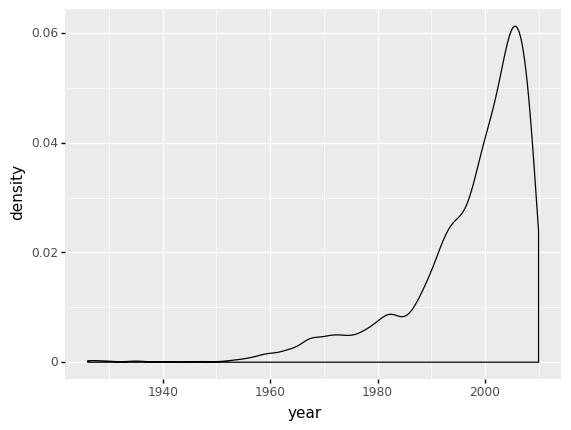

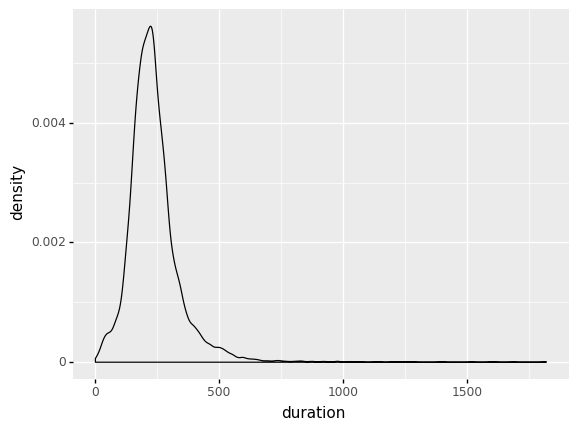

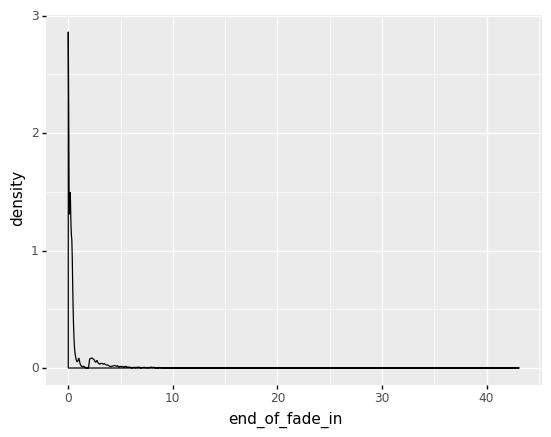

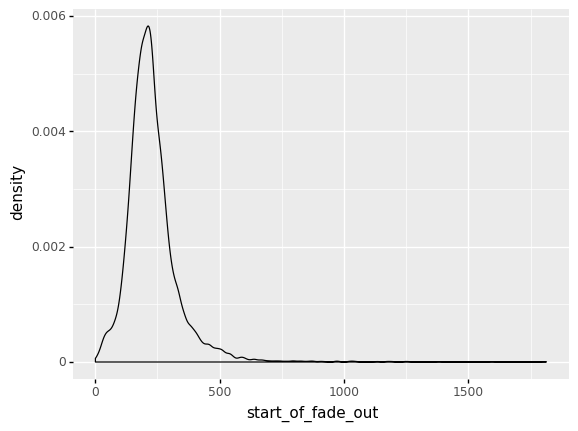

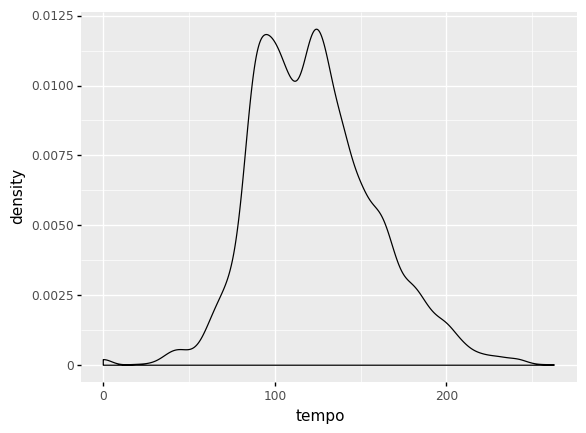

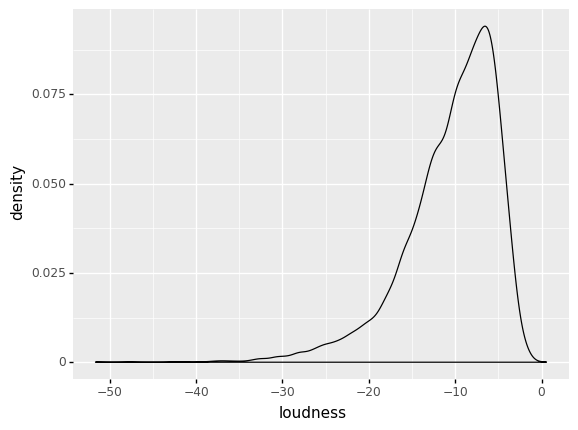

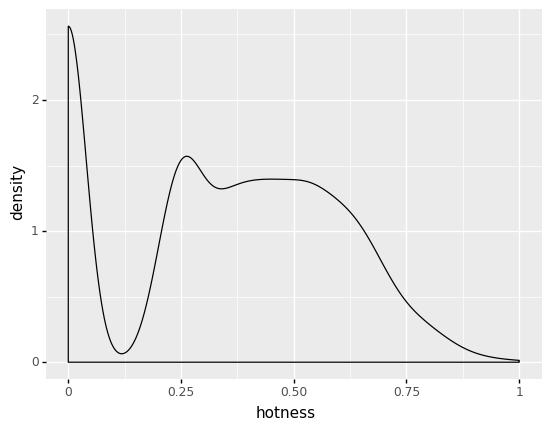

In [12]:
# Densidad para numéricas
for col in numerical_features:
    (ggplot(data.select(col).toPandas(), aes(x=col)) + geom_density()).draw()

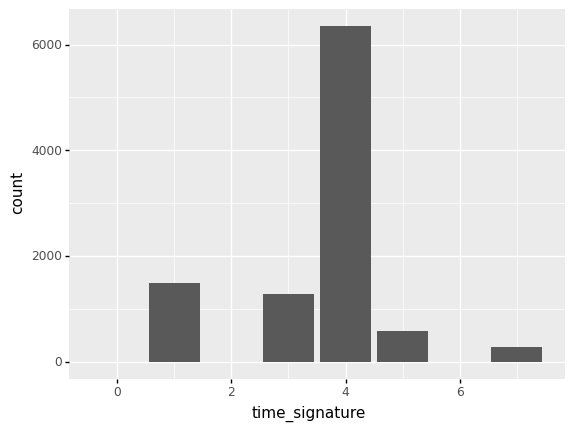

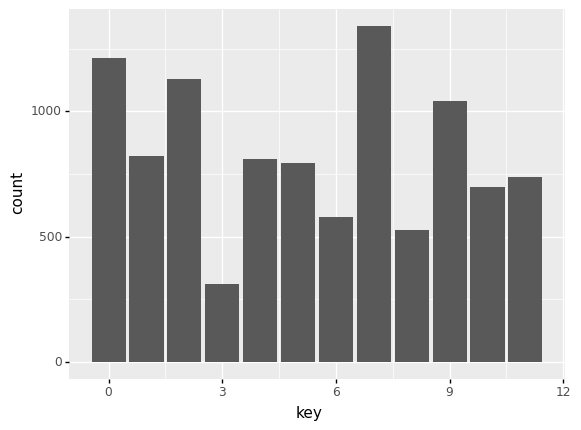

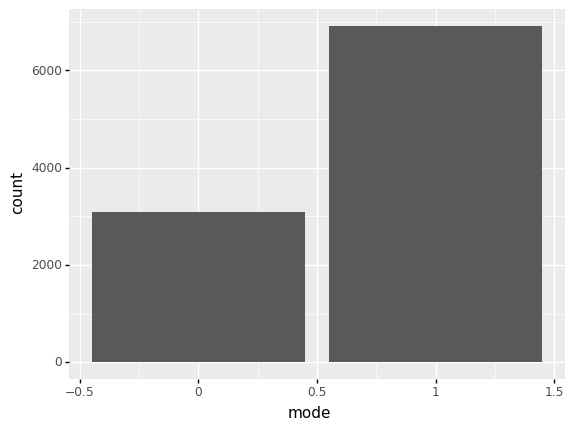

In [13]:
# Conteos de valores únicos para categóricas
for col in categorical_features:
    (ggplot(data.groupby(col).count().toPandas(), aes(x=col, y='count')) + geom_bar(stat='identity')).draw()

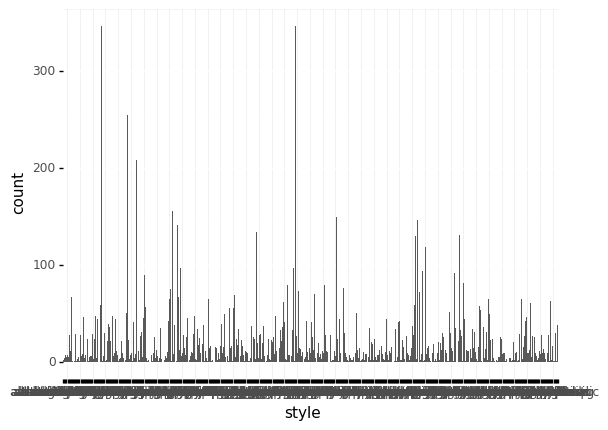

<ggplot: (-9223363306243181231)>

In [14]:
col = 'style'
d = data.filter(~data.style.isNull())
(ggplot(d.groupby(col).count().toPandas(), aes(x=col, y='count')) + geom_bar(stat='identity'))

De las gráficas anteriores se observan varios hechos como que la mayor parte de las canciones son cercanas a los 2000, pero no se observa ningún elemento anómalo. Lo más notable es la diferencia de escala que existe entre las distintas variables y que para el desarrollo de los modelos tendrá que ser corregida.

## Preprocesado 

En la etapa de preprocesado de los datos se llevan a cabo tareas como imputación de *missing values*, codificación de variables categóricas, vectorización, entre otras. Uno de los pasos iniciales es la imputación de *missing values*. Algunas de las variables que deben ser imputadas son categóricas y actualmente Spark no soporta la imputación de variables categóricas y puede llegar a producir valores incorrectos en esos casos. Por lo tanto, para las observaciones que tienen las variables *title* y *style* en null generamos una cadena de caracteres diferente a las existentes que luego serán codificadas como una categoría más. 

### Imputación de *missings*

Teniendo en cuenta los hechos observados en en análisis exploratorio se decide:

* Imputar los ceros en la variable *year* con la media
* Imputar los *missing values* de la variable hotness con la media
* Imputar los *missing values* de las variables *style* y *title* con una nueva cadena que represente valor inválido.

In [15]:
data = data.select('id', 'title', 'year', 'hotness', 'id_artist', 'id_album', 'duration',
                   'end_of_fade_in', 'start_of_fade_out', 'tempo', 'time_signature',
                   'key', 'loudness', 'mode',                    
                   F.when(data.style.isNull(), 'None').otherwise(data.style).alias('style'))

data = data.select('id', 'year', 'hotness', 'id_artist', 'id_album', 'duration',
                   'end_of_fade_in', 'start_of_fade_out', 'tempo', 'time_signature',
                   'key', 'loudness', 'mode',  'style',                  
                   F.when(data.title.isNull(), '').otherwise(data.title).alias('title'))

original_data = data
imputer = Imputer(inputCols=['year', 'hotness'], outputCols=['imputed_year', 'imputed_hotness'], strategy='mean')
trained_imputer = imputer.fit(data)

imputed_data = trained_imputer.transform(data)
imputed_data.dtypes

[('id', 'string'),
 ('year', 'double'),
 ('hotness', 'double'),
 ('id_artist', 'string'),
 ('id_album', 'int'),
 ('duration', 'double'),
 ('end_of_fade_in', 'double'),
 ('start_of_fade_out', 'double'),
 ('tempo', 'double'),
 ('time_signature', 'int'),
 ('key', 'int'),
 ('loudness', 'double'),
 ('mode', 'int'),
 ('style', 'string'),
 ('title', 'string'),
 ('imputed_year', 'double'),
 ('imputed_hotness', 'double')]

### Codificación de variables categóricas

En el conjunto de datos existen varias variables categóricas según fueron idenificadas anteriormente.

* La variable *mode* que indica si el tipo de escala de la canción es mayor (= 0) o menor (= 1). Esta variable no necesita ser codificada porque ya está expresada de forma numérica.
* La variable *key* puede ser considera categórica pero no necesita transformación.

In [16]:
imputed_data.select('style').distinct().count()

458

* La variable *style* es categórica. En este caso, tenemos dos opciones: codificarla empleando el indexado estándar o el método one-hot *encoding*. El número de categorías de esta variable es muy grande (458 categorías diferentes) respecto a la cantidad de variables total por lo que una codificación *one-hot* resutaría en un vector de alta dimensión que puede distorsionar los modelos de aprendizaje a desarrollar. Por esta razón, se utilizará la indexación como método de codificación.

In [17]:
indexer = StringIndexer(inputCol='style', outputCol='style_indexed')
trained_indexer = indexer.fit(imputed_data)

transf_data = trained_indexer.transform(imputed_data)

### Target vs. features

En este apartado se definen las variables predictoras y la variable objetivo. Las variables predictoras serán todas aquellas variables numéricas y categóricas (codificadas) que no representen información identificativa de una canción.
Por ejemplo, el identificador, el título, el artista, ..., no serán incluidas en el modelo. Asimismo, al calcular las correlaciones entre las variables se notó que las variables *duration* y *start_of_fade_out* están altamente correlacionadas, por lo tanto, es aconsejable eliminar una de las dos, eliminaremos *end_of_fade_out*

In [18]:
target = 'imputed_hotness'
features = ['imputed_year', 'duration', 'end_of_fade_in', 'tempo', 
            'time_signature', 'key', 'loudness', 'mode', 'style_indexed']

### Vectorización

Con el objetivo de preparar los datos como entrada a los modelos es necesario vectorizarlos utilizando el tipo VectorAssembler de Spark. 

In [19]:
assembler = VectorAssembler(inputCols=features, outputCol='features')
vectorized_data = assembler.transform(transf_data)
vectorized_data.select('features').show(5)

+--------------------+
|            features|
+--------------------+
|[1997.23205128205...|
|[1997.23205128205...|
|[1991.0,415.81669...|
|[1997.23205128205...|
|[2009.0,224.7571,...|
+--------------------+
only showing top 5 rows



### Escalado de variables - Standard

Dado que la mayoría de las variables son de tiplo double es posible estandarizar los datos con el objetivo de expresar toda la información a una misma escala para lograr que los modelos de aprendizaje le presten la misma atención durante el entrenamiento.Se aplica el escalado estándar.

In [20]:
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withMean=True, withStd=True)

trained_scaler = scaler.fit(vectorized_data)
scaled_data = trained_scaler.transform(vectorized_data)
scaled_data.select('features', 'scaledFeatures').show(5)

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[1997.23205128205...|[1.42199692117846...|
|[1997.23205128205...|[1.42199692117846...|
|[1991.0,415.81669...|[-0.7795060460210...|
|[1997.23205128205...|[1.42199692117846...|
|[2009.0,224.7571,...|[1.47193704925517...|
+--------------------+--------------------+
only showing top 5 rows



### Split train - test

In [21]:
train, test = scaled_data.randomSplit([0.7, 0.3], seed=42)
print(f"Tamaño del conjunto train: {(train.count(), len(train.columns))}")
print(f"Tamalo del conjunto test: {(test.count(), len(test.columns))}")

Tamaño del conjunto train: (7039, 20)
Tamalo del conjunto test: (2960, 20)


## Modelos

En esta sección se proponen un conjunto de modelos para predecir el valor de la variable *hotness* a partir de las variables predictoras determinadas anteriormente. Los datos, como entrada, están siempre representados de la misma forma. Para evitar la repetición del código en el preprocesado de los datos se propone utilizar *pipelines* que nos permiten definir el flujo continuo en el desarrollo de un modelo.

Los pasos, como han sido desarrollados anteriormente, serían:

* imputer: imputación de *missing values*
* indexer: codificación de variables categóricas
* assembler: vectorización de Spark
* scaler: Estandarización de variables
* estimator: Modelo de aprendizaje a entrenar y evaluar

El pipeline se utiliza en el segundo modelo presentado donde se hace una modificación en el proceso de vectorización, en este modelo no es necesario puesto que ya tenemos los datos transformados.

En cada caso, se definen y entrenan los modelos (en algunos casos se realiza *tuning* de parámetros) y posteriormente se evalúan. Las métricas de error consideradas para evaluar los modelos de regresión son: RMSE, MSE, MAE y R2. Aunque en cada caso se presentan todos los valores obtenidos, la métrica que regirá el análisis es el RMSE. Si bien se conoce que la elección de la métrica depende del problema en cuestión, en este caso se ha decidio utilizar el RMSE porque permite conocer el ajuste absoluto del modelo a los datos, qué tan cerca están los valores predichos de los reales. Además, es aconsejable su uso cuando el objetivo de la tarea es la predicción.

### Regresión lineal 

Primeramente, se presenta un regresor lineal. Se define una matriz de posibles parámetros y se realiza *tuning* de los parámetros del modelo a través de la clase *TrainValidationSplit*, que divide el conjunto de entrenamiento en *train* y *validation* lo cual contribuye a desarrollar modelos menos propensos al *overfitting*. 

In [22]:
## Creación del estimador
lr = LinearRegression(
    featuresCol='features', 
    labelCol=target, 
    predictionCol='prediction', 
    regParam=0,
    elasticNetParam=0,
    fitIntercept=True,
    standardization=False
)

## Creación del evaluador
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol=target, metricName='rmse')

## Matriz de parámetros
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0, 0.5, 1.0]) \
    .addGrid(lr.elasticNetParam, [0, 0.5, 1.0]) \
    .addGrid(lr.fitIntercept, [False, True]) \
    .build()

## Cross-validator
trainvalidator = TrainValidationSplit(estimator=lr, 
                               evaluator=evaluator, 
                               estimatorParamMaps=paramGrid, 
                               trainRatio=0.7)

#Entrenamiento
trained_tvs = trainvalidator.fit(train)

A continuación, se listan todos los modelos considerados según los parámetros y cada uno de los errores alcanzados.

In [23]:
## Listamos el error alcanzado por cada combinación de parámetros del modelo

for i, combination in enumerate(paramGrid):
    combination_values = {}
    for param, value in combination.items():
        combination_values[param.name] = value
    print(f'{combination_values} --> {trained_tvs.validationMetrics[i]}')

{'regParam': 0.0, 'elasticNetParam': 0.0, 'fitIntercept': False} --> 0.18685534131338924
{'regParam': 0.0, 'elasticNetParam': 0.0, 'fitIntercept': True} --> 0.18685226117302545
{'regParam': 0.0, 'elasticNetParam': 0.5, 'fitIntercept': False} --> 0.18685534131338924
{'regParam': 0.0, 'elasticNetParam': 0.5, 'fitIntercept': True} --> 0.18685226117302545
{'regParam': 0.0, 'elasticNetParam': 1.0, 'fitIntercept': False} --> 0.18685534131338924
{'regParam': 0.0, 'elasticNetParam': 1.0, 'fitIntercept': True} --> 0.18685226117302545
{'regParam': 0.5, 'elasticNetParam': 0.0, 'fitIntercept': False} --> 0.1869372795091877
{'regParam': 0.5, 'elasticNetParam': 0.0, 'fitIntercept': True} --> 0.18692985015674654
{'regParam': 0.5, 'elasticNetParam': 0.5, 'fitIntercept': False} --> 0.189337452845533
{'regParam': 0.5, 'elasticNetParam': 0.5, 'fitIntercept': True} --> 0.18942042061884604
{'regParam': 0.5, 'elasticNetParam': 1.0, 'fitIntercept': False} --> 0.18948912009215713
{'regParam': 0.5, 'elasticNet

In [24]:
## Mejor modelo
best_lr = trained_tvs.bestModel

for param, value in best_lr.extractParamMap().items():
    print(f'{param.name}: {value}')

aggregationDepth: 2
elasticNetParam: 0.0
epsilon: 1.35
featuresCol: features
fitIntercept: True
labelCol: imputed_hotness
loss: squaredError
maxIter: 100
predictionCol: prediction
regParam: 0.0
solver: auto
standardization: False
tol: 1e-06


In [25]:
# Obtenemos los valores asociados a la regresión
coefs = list(best_lr.coefficients.toArray()) + [best_lr.intercept]
pvalues = best_lr.summary.pValues
pd.DataFrame({
    'features': features + ['Intercept'], 
    'coefficients': coefs,
    'pvalues': pvalues
})

,features,coefficients,pvalues
0,imputed_year,0.000854,0.001871
1,duration,-0.000028,0.149018
2,end_of_fade_in,0.002410,0.040552
3,tempo,0.000141,0.026160
4,time_signature,0.000217,0.901330
5,key,0.000090,0.885135
6,loudness,0.005389,0.000000
7,mode,-0.004291,0.371647
8,style_indexed,-0.000048,0.044369
9,Intercept,-1.313916,0.016732


Una vez entrenados los modelos, se pasa a la fase de validación. En esta fase se calculan las métricas mencionadas tanto en el conjunto de *train* como en *test*.

In [26]:
## Evaluación

# Obtenemos predicciones en train y en test
train_preds = best_lr.transform(train)
test_preds = best_lr.transform(test)

# Evaluamos en train
train_rmse = evaluator.evaluate(train_preds, {evaluator.metricName: 'rmse'})
train_mse = evaluator.evaluate(train_preds, {evaluator.metricName: 'mse'})
train_r2 = evaluator.evaluate(train_preds, {evaluator.metricName: 'r2'})
train_mae = evaluator.evaluate(train_preds, {evaluator.metricName: 'mae'})

# Evaluamos en test
test_rmse = evaluator.evaluate(test_preds, {evaluator.metricName: 'rmse'})
test_mse = evaluator.evaluate(test_preds, {evaluator.metricName: 'mse'})
test_r2 = evaluator.evaluate(test_preds, {evaluator.metricName: 'r2'})
test_mae = evaluator.evaluate(test_preds, {evaluator.metricName: 'mae'})

# Comparamos restulados
print(f'RMSE (Train/Test): {train_rmse} / {test_rmse}')
print(f'MSE (Train/Test): {train_mse} / {test_mse}')
print(f'R2 (Train/Test): {train_r2} / {test_r2}')
print(f'MAE (Train/Test): {train_mae} / {test_mae}')

RMSE (Train/Test): 0.18192163096539363 / 0.18563227828960302
MSE (Train/Test): 0.03309547981310887 / 0.03445934274298862
R2 (Train/Test): 0.030467914341178015 / 0.02712616464132922
MAE (Train/Test): 0.12503867182431014 / 0.1292926969335715


Se puede apreciar, por la cercanía de las métricas en *train* y *test* que el modelo no sufre de *overfitting*, más bien, al observar la siguiente gráfica se podría pensar que sufre de *underfitting*.

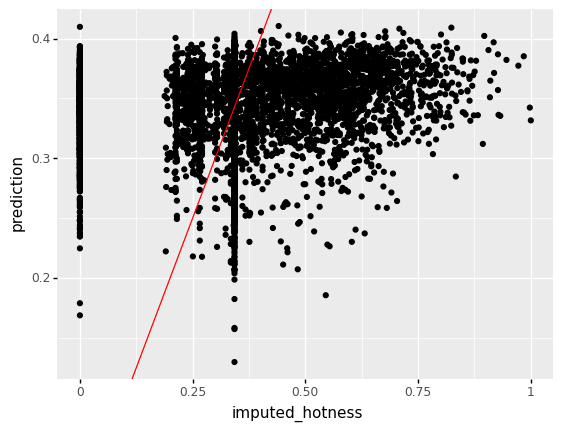

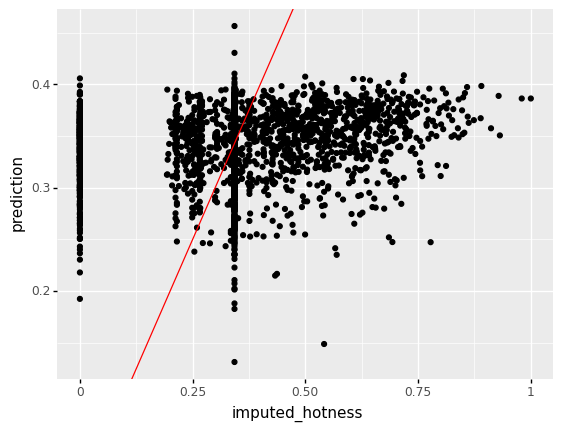

<ggplot: (-9223363306243376910)>

In [27]:
# Mostramos resultados en train
train_results = train_preds.select(target, 'prediction').toPandas()
(
    ggplot(train_results, aes(x=target, y='prediction')) + 
        geom_point() + 
        geom_abline(slope=1, intercept=0, colour='red')
).draw()

# Mostramos resultados en test
test_results = test_preds.select(target, 'prediction').toPandas()
(
    ggplot(test_results, aes(x=target, y='prediction')) + 
        geom_point() + 
        geom_abline(slope=1, intercept=0, colour='red')
)

Al analizar las métricas de error y las gráficas podemos notar que aunque los datos no son representables por una línea, el modelo lineal podría haber concluido con una función más cercana. Los coeficientes de la regresión se ven distorsionados porque tienen un beta muy pequeño, siendo las variable *key* la de menor peso. Por lo tanto, se considera construir otro regresor lineal donde no se tenga en cuenta dicha variable. 

Como hemos visto anteriormente, los diferentes modelos entrenados no divergen en gran medida, por lo que en este punto se considera que no es necesario el *tuning* de parámetros para el siguiente regresor. El pipeline introducido al inicio será utilizado aquí.

### Regresión lineal  2

In [28]:
target = 'imputed_hotness'
new_features = ['imputed_year', 'duration', 'end_of_fade_in', 'tempo', 
            'time_signature', 'key', 'loudness', 'mode']

#Vectorización: al cambiar el conjunto de variables predictoras el *vectorizer* debe ser redefinido 
assembler = VectorAssembler(inputCols=new_features, outputCol='features')

lr_2 = LinearRegression(
    featuresCol='scaledFeatures', 
    labelCol=target, 
    predictionCol='prediction', 
    regParam=0,
    elasticNetParam=0,
    fitIntercept=True,
    standardization=False
)

pipeline = Pipeline(stages=[imputer, indexer, assembler, lr])

new_train, new_test = original_data.randomSplit([0.7, 0.3], seed=42)

trained_lr2 = pipeline.fit(new_train)

In [29]:
# Creamos un objeto de evaluación de resultados
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol=target)

# Obtenemos predicciones en train y en test
train_preds = trained_lr2.transform(new_train)
test_preds = trained_lr2.transform(new_test)

# Evaluamos en train
train_rmse = evaluator.evaluate(train_preds, {evaluator.metricName: 'rmse'})
train_mse = evaluator.evaluate(train_preds, {evaluator.metricName: 'mse'})
train_r2 = evaluator.evaluate(train_preds, {evaluator.metricName: 'r2'})
train_mae = evaluator.evaluate(train_preds, {evaluator.metricName: 'mae'})

# Evaluamos en test
test_rmse = evaluator.evaluate(test_preds, {evaluator.metricName: 'rmse'})
test_mse = evaluator.evaluate(test_preds, {evaluator.metricName: 'mse'})
test_r2 = evaluator.evaluate(test_preds, {evaluator.metricName: 'r2'})
test_mae = evaluator.evaluate(test_preds, {evaluator.metricName: 'mae'})

# Comparamos restulados
print(f'RMSE (Train/Test): {train_rmse} / {test_rmse}')
print(f'MSE (Train/Test): {train_mse} / {test_mse}')
print(f'R2 (Train/Test): {train_r2} / {test_r2}')
print(f'MAE (Train/Test): {train_mae} / {test_mae}')

RMSE (Train/Test): 0.18196195835858506 / 0.18560195102441307
MSE (Train/Test): 0.03311015428969145 / 0.03444808422406863
R2 (Train/Test): 0.030031003536321044 / 0.02748167100651977
MAE (Train/Test): 0.12496489528951076 / 0.12916367055293454


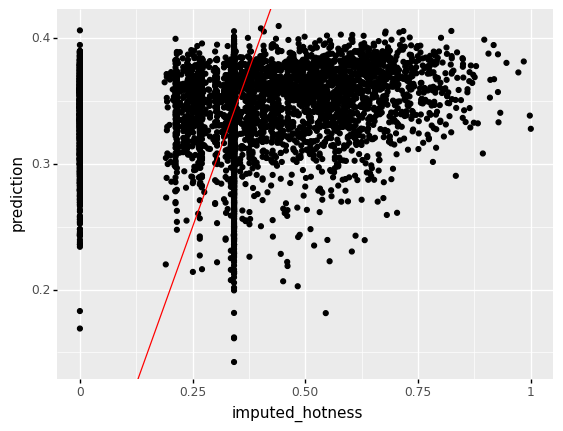

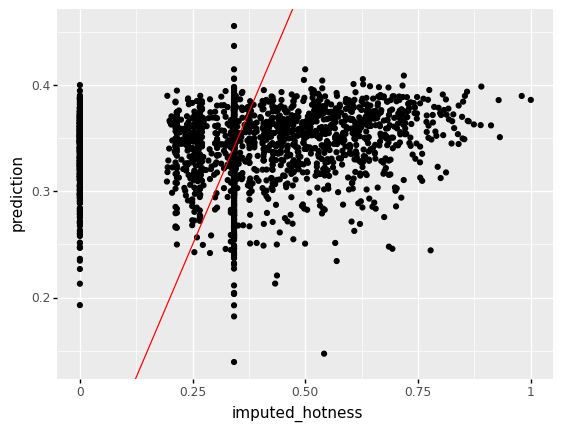

<ggplot: (-9223363306247308165)>

In [30]:
train_results = train_preds.select(target, 'prediction').toPandas()
(
    ggplot(train_results, aes(x=target, y='prediction')) + 
        geom_point() + 
        geom_abline(slope=1, intercept=0, colour='red')
).draw()

test_results = test_preds.select(target, 'prediction').toPandas()
(
    ggplot(test_results, aes(x=target, y='prediction')) + 
        geom_point() + 
        geom_abline(slope=1, intercept=0, colour='red')
)

Al eliminar la variable no hubo grandes cambios en las predicciones (el error aumentó en el tercer decimal, no es muy importante), por lo tanto, hasta el momento nos quedamos con el primer modelo. A continuación, se presentan un conjunto de modelos basados en árboles de decisión.

### Árbol de decision

La idea que se sigue en el desarrollo de estos modelos es la misma que la empleada en los regresores lineales.

In [31]:
# Creamos un objeto DecisionTree
tree = DecisionTreeRegressor(
    featuresCol='scaledFeatures', 
    labelCol=target, 
    predictionCol='prediction', 
    maxDepth=5,
    minInstancesPerNode=1
)

## Creación del evaluador
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol=target, metricName='rmse')

## Matriz de parámetros
paramGrid = ParamGridBuilder() \
    .addGrid(tree.maxDepth, [5, 10, 25, 30]).build()

## Cross-validator
trainvalidator = TrainValidationSplit(estimator=tree, 
                               evaluator=evaluator, 
                               estimatorParamMaps=paramGrid, 
                               trainRatio=0.7)

#Entrenamiento
trained_tree = trainvalidator.fit(train)

In [32]:
for i, combination in enumerate(paramGrid):
    combination_values = {}
    for param, value in combination.items():
        combination_values[param.name] = value
    print(f'{combination_values} --> {trained_tree.validationMetrics[i]}')

{'maxDepth': 5} --> 0.1783062790500366
{'maxDepth': 10} --> 0.19905313147115675
{'maxDepth': 25} --> 0.24706858685321173
{'maxDepth': 30} --> 0.24717990847821097


In [33]:
best_tree = trained_tree.bestModel

for param, value in best_tree.extractParamMap().items():
    print(f'{param.name}: {value}')

cacheNodeIds: False
checkpointInterval: 10
featuresCol: scaledFeatures
impurity: variance
labelCol: imputed_hotness
maxBins: 32
maxDepth: 5
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
predictionCol: prediction
seed: -1407754390808368278


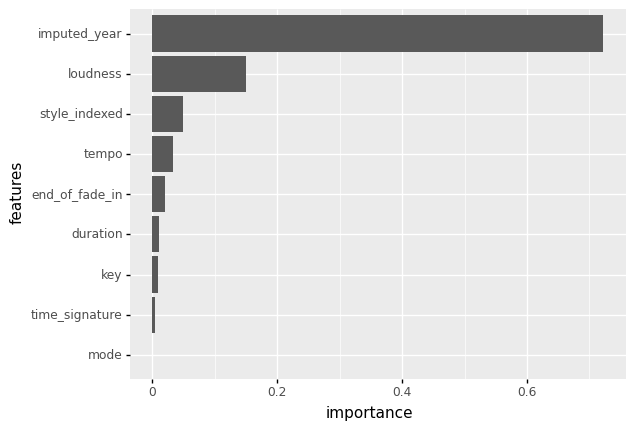

<ggplot: (-9223363306268396193)>

In [34]:
importance = best_tree.featureImportances.toArray()
results = pd.DataFrame({
    'features': features, 
    'importance': importance,
})
(
    ggplot(results, aes(x='features', y='importance')) + 
        geom_bar(stat='identity') + 
        coord_flip() + 
        scale_x_discrete(limits=results.sort_values('importance')['features'])
)

Al analizar la importancia de cada una de las variables en la decisión de predicción se puede notar que al igual que en regresión lineal, la mayoría de las variables tienen muy poco peso, aunque en este caso, el orden de prioridad cambia un poco.

In [35]:
# Obtenemos predicciones en train y en test
train_preds = best_tree.transform(train)
test_preds = best_tree.transform(test)

# Evaluamos en train
train_rmse = evaluator.evaluate(train_preds, {evaluator.metricName: 'rmse'})
train_mse = evaluator.evaluate(train_preds, {evaluator.metricName: 'mse'})
train_r2 = evaluator.evaluate(train_preds, {evaluator.metricName: 'r2'})
train_mae = evaluator.evaluate(train_preds, {evaluator.metricName: 'mae'})

# Evaluamos en test
test_rmse = evaluator.evaluate(test_preds, {evaluator.metricName: 'rmse'})
test_mse = evaluator.evaluate(test_preds, {evaluator.metricName: 'mse'})
test_r2 = evaluator.evaluate(test_preds, {evaluator.metricName: 'r2'})
test_mae = evaluator.evaluate(test_preds, {evaluator.metricName: 'mae'})

# Comparamos restulados
print(f'RMSE (Train/Test): {train_rmse} / {test_rmse}')
print(f'MSE (Train/Test): {train_mse} / {test_mse}')
print(f'R2 (Train/Test): {train_r2} / {test_r2}')
print(f'MAE (Train/Test): {train_mae} / {test_mae}')

RMSE (Train/Test): 0.1694576869868702 / 0.17524922282498268
MSE (Train/Test): 0.028715907678940073 / 0.030712290100760424
R2 (Train/Test): 0.15876748061161683 / 0.13291487635659005
MAE (Train/Test): 0.1277628654759023 / 0.13208447665348497


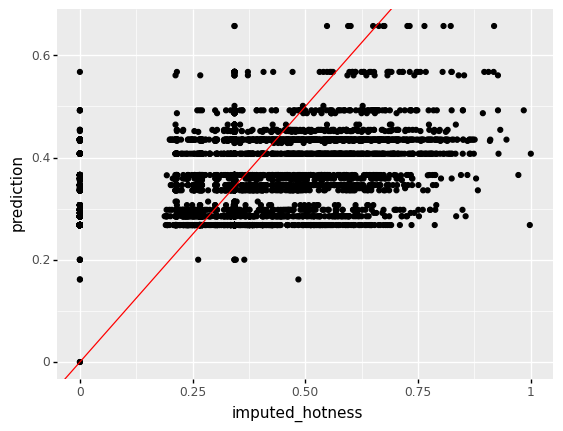

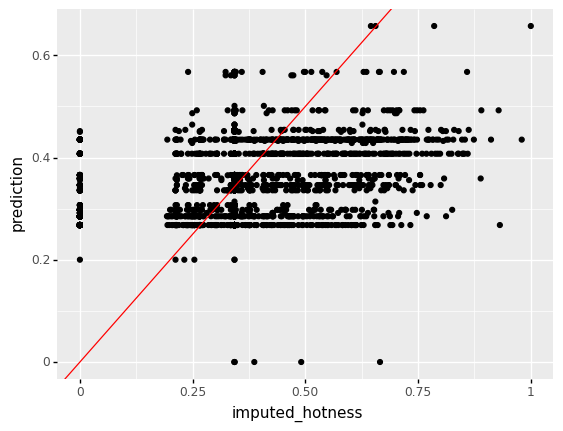

<ggplot: (-9223363306270535480)>

In [36]:
# Mostramos resultados en train
train_results = train_preds.select(target, 'prediction').toPandas()
(
    ggplot(train_results, aes(x=target, y='prediction')) + 
        geom_point() + 
        geom_abline(slope=1, intercept=0, colour='red')
).draw()


# Mostramos resultados en test
test_results = test_preds.select(target, 'prediction').toPandas()
(
    ggplot(test_results, aes(x=target, y='prediction')) + 
        geom_point() + 
        geom_abline(slope=1, intercept=0, colour='red')
)

En este modelo aplicamos *tuning* para seleccionar la profundidad del aŕbol construido, aunque el mejor resultado se obtuvo con una profundidad  de 5 que es el valor del parámetro por defecto. Se puede observar que el error se redujo respecto al regresor lineal entrenado anteriormente, sin embargo los resultados no son buenos.

### Random Forest

In [37]:
# Creamos un objeto RandomForest
rf = RandomForestRegressor(
    featuresCol='scaledFeatures', 
    labelCol=target, 
    predictionCol='prediction', 
    numTrees=100,
    maxDepth=8,
    minInstancesPerNode=5
)


## Creación del evaluador
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol=target, metricName='rmse')

## Matriz de parámetros
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10, 25, 30]) \
    .addGrid(rf.numTrees, [20, 50, 100]).build()

## Cross-validator
trainvalidator = TrainValidationSplit(estimator=rf, 
                               evaluator=evaluator, 
                               estimatorParamMaps=paramGrid, 
                               trainRatio=0.7)

#Entrenamiento
trained_rf = trainvalidator.fit(train)

In [38]:
for i, combination in enumerate(paramGrid):
    combination_values = {}
    for param, value in combination.items():
        combination_values[param.name] = value
    print(f'{combination_values} --> {trained_rf.validationMetrics[i]}')

{'maxDepth': 5, 'numTrees': 20} --> 0.17776958549793084
{'maxDepth': 5, 'numTrees': 50} --> 0.17710842456955767
{'maxDepth': 5, 'numTrees': 100} --> 0.17727325902395794
{'maxDepth': 10, 'numTrees': 20} --> 0.17792323342349733
{'maxDepth': 10, 'numTrees': 50} --> 0.17660977324997365
{'maxDepth': 10, 'numTrees': 100} --> 0.1769478816029915
{'maxDepth': 25, 'numTrees': 20} --> 0.17945286396850754
{'maxDepth': 25, 'numTrees': 50} --> 0.17809674034972495
{'maxDepth': 25, 'numTrees': 100} --> 0.17755644798038248
{'maxDepth': 30, 'numTrees': 20} --> 0.1794470338443958
{'maxDepth': 30, 'numTrees': 50} --> 0.17809668290075262
{'maxDepth': 30, 'numTrees': 100} --> 0.1775614077301509


In [39]:
best_rf = trained_rf.bestModel

for param, value in best_rf.extractParamMap().items():
    print(f'{param.name}: {value}')

cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: auto
featuresCol: scaledFeatures
impurity: variance
labelCol: imputed_hotness
maxBins: 32
maxDepth: 10
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 5
numTrees: 50
predictionCol: prediction
seed: 2502083311556356884
subsamplingRate: 1.0


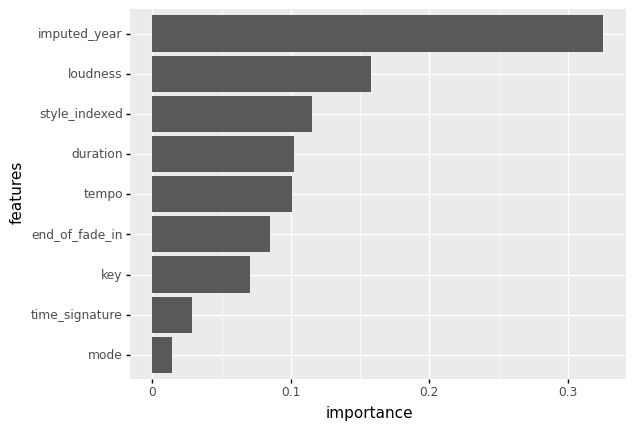

<ggplot: (-9223363306243099132)>

In [40]:
importance = best_rf.featureImportances.toArray()
results = pd.DataFrame({
    'features': features, 
    'importance': importance,
})
(
    ggplot(results, aes(x='features', y='importance')) + 
        geom_bar(stat='identity') + 
        coord_flip() + 
        scale_x_discrete(limits=results.sort_values('importance')['features'])
)

In [41]:
# Obtenemos predicciones en train y en test
train_preds = best_rf.transform(train)
test_preds = best_rf.transform(test)

# Evaluamos en train
train_rmse = evaluator.evaluate(train_preds, {evaluator.metricName: 'rmse'})
train_mse = evaluator.evaluate(train_preds, {evaluator.metricName: 'mse'})
train_r2 = evaluator.evaluate(train_preds, {evaluator.metricName: 'r2'})
train_mae = evaluator.evaluate(train_preds, {evaluator.metricName: 'mae'})

# Evaluamos en test
test_rmse = evaluator.evaluate(test_preds, {evaluator.metricName: 'rmse'})
test_mse = evaluator.evaluate(test_preds, {evaluator.metricName: 'mse'})
test_r2 = evaluator.evaluate(test_preds, {evaluator.metricName: 'r2'})
test_mae = evaluator.evaluate(test_preds, {evaluator.metricName: 'mae'})

# Comparamos restulados
print(f'RMSE (Train/Test): {train_rmse} / {test_rmse}')
print(f'MSE (Train/Test): {train_mse} / {test_mse}')
print(f'R2 (Train/Test): {train_r2} / {test_r2}')
print(f'MAE (Train/Test): {train_mae} / {test_mae}')

RMSE (Train/Test): 0.14862351450200018 / 0.17354161205310148
MSE (Train/Test): 0.022088949062926255 / 0.030116691113989173
R2 (Train/Test): 0.35290423417557826 / 0.14973013237924826
MAE (Train/Test): 0.11064941465303436 / 0.12891515177708024


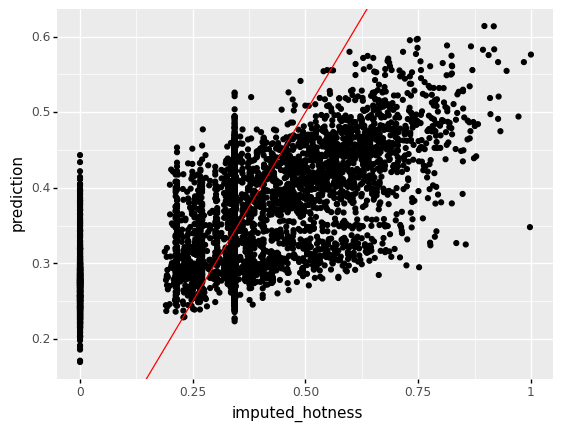

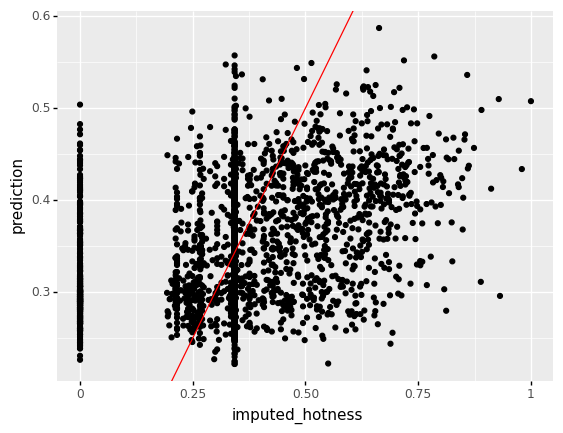

<ggplot: (8730620749127)>

In [42]:
train_results = train_preds.select(target, 'prediction').toPandas()
(
    ggplot(train_results, aes(x=target, y='prediction')) + 
        geom_point() + 
        geom_abline(slope=1, intercept=0, colour='red')
).draw()

test_results = test_preds.select(target, 'prediction').toPandas()
(
    ggplot(test_results, aes(x=target, y='prediction')) + 
        geom_point() + 
        geom_abline(slope=1, intercept=0, colour='red')
)

El error se redujo un poco más al utilizar el algoritmo Random Forest, sin embargo las gráficas siguen mostrando que el modelo está lejos de generalizar los datos. El error, según los parámetros no varía mucho para el tiempo que toma ejecutar esta técnica. Por lo tanto, en el siguiente modelo a ejecutar no se utilizará *tuning*.

## Gradient Boosted Tree

In [43]:
# Creamos un objeto GBTRegresor
gbt = GBTRegressor(
    featuresCol='scaledFeatures', 
    labelCol=target, 
    predictionCol='prediction', 
    maxIter=20,
    maxDepth=8,
    minInstancesPerNode=5
)

## Creación del evaluador
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol=target, metricName='rmse')

#Entrenamiento
trained_gbt = gbt.fit(train)

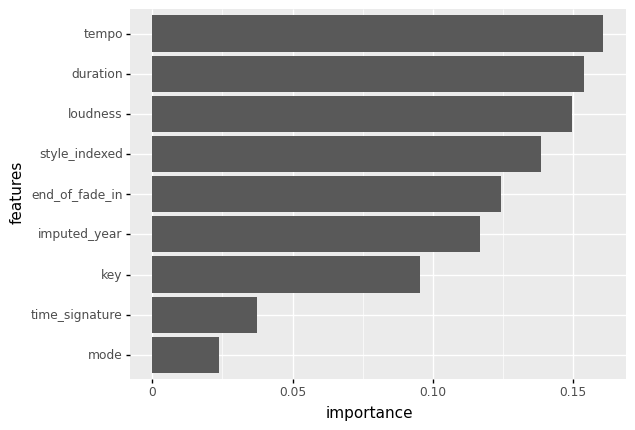

<ggplot: (8730611247368)>

In [44]:
importance = trained_gbt.featureImportances.toArray()
results = pd.DataFrame({
    'features': features, 
    'importance': importance,
})
(
    ggplot(results, aes(x='features', y='importance')) + 
        geom_bar(stat='identity') + 
        coord_flip() + 
        scale_x_discrete(limits=results.sort_values('importance')['features'])
)

In [45]:
# Creamos un objeto de evaluación de resultados
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol=target)

# Obtenemos predicciones en train y en test
train_preds = trained_gbt.transform(train)
test_preds = trained_gbt.transform(test)

# Evaluamos en train
train_rmse = evaluator.evaluate(train_preds, {evaluator.metricName: 'rmse'})
train_mse = evaluator.evaluate(train_preds, {evaluator.metricName: 'mse'})
train_r2 = evaluator.evaluate(train_preds, {evaluator.metricName: 'r2'})
train_mae = evaluator.evaluate(train_preds, {evaluator.metricName: 'mae'})

# Evaluamos en test
test_rmse = evaluator.evaluate(test_preds, {evaluator.metricName: 'rmse'})
test_mse = evaluator.evaluate(test_preds, {evaluator.metricName: 'mse'})
test_r2 = evaluator.evaluate(test_preds, {evaluator.metricName: 'r2'})
test_mae = evaluator.evaluate(test_preds, {evaluator.metricName: 'mae'})

# Comparamos restulados
print(f'RMSE (Train/Test): {train_rmse} / {test_rmse}')
print(f'MSE (Train/Test): {train_mse} / {test_mse}')
print(f'R2 (Train/Test): {train_r2} / {test_r2}')
print(f'MAE (Train/Test): {train_mae} / {test_mae}')

RMSE (Train/Test): 0.12633577135545618 / 0.18459065557632082
MSE (Train/Test): 0.0159607271239781 / 0.0340737101260959
R2 (Train/Test): 0.5324304967165785 / 0.03801354243706967
MAE (Train/Test): 0.09468182597695661 / 0.14015851921687125


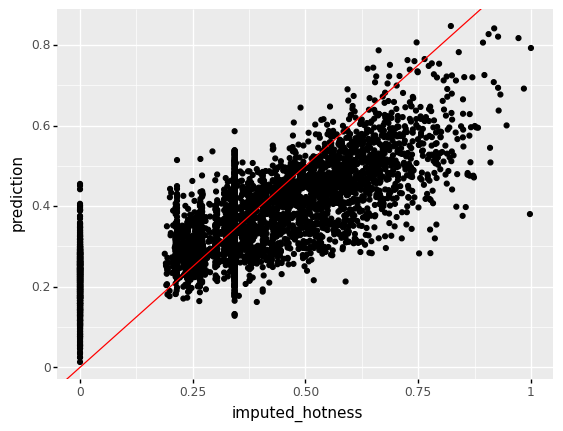

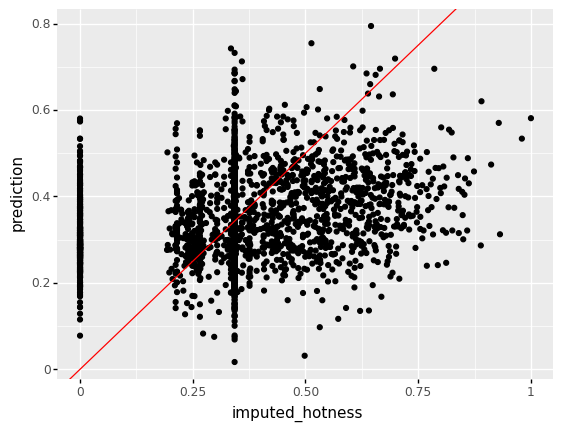

<ggplot: (-9223363306243089604)>

In [46]:
train_results = train_preds.select(target, 'prediction').toPandas()
(
    ggplot(train_results, aes(x=target, y='prediction')) + 
        geom_point() + 
        geom_abline(slope=1, intercept=0, colour='red')
).draw()

# Mostramos resultados en test
test_results = test_preds.select(target, 'prediction').toPandas()
(
    ggplot(test_results, aes(x=target, y='prediction')) + 
        geom_point() + 
        geom_abline(slope=1, intercept=0, colour='red')
)

Al analizar los resultados de Gradient Boosting se puede notar que la importancia de las variables se ha equiparado bastante respecto a otros modelos. Asimismo, el error se ha reducido en comparación con el primer modelo, aunque como se ha discutido los modelos presentados no se ajustan a la naturaleza de los datos. Para trabajos futuros se podría considerar la incorporación de la variable *id_artist*, puesto que el artista puede tener influencia en la popularidad de una canción. Otra alternativa interesante sería imputar los *missing values* de la variable objetivo con los valores de popularidad del artista que interpreta dicha canción, de esa forma obtendríamos una mejor aproximación que imputando con la media. Asimismo, se podría incursionar con el uso de otras codificaciones como *one-hot* para las variables categóricas.

## Conclusiones

En este trabajo se ha llevado a cabo un proceso de carga, limpieza y preprocesamiento de los datos sobre los que se han construido y evaluado un conjunto de modelo de regresión. De manera general y atendiendo al error y el ajuste obtenidos se puede afirmar que ninguno de los modelos seleccionados tiene la capacidad suficiente para ajustar los datos del problema. Una posible causa puede ser la imputación de la variable objetivo, puesto que en realidad se han asignado etiquetas incorrectas (irreales) a las observaciones. En un escenario real, como se ha explicado anteriormente, esta técnica no tendría ningún sentido y sería una mejor alternativa eliminar las instancias que no tienen valor objetivo aunque disminuya el tamaño del *dataset*.